In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import urllib2
import folium
import json
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import scipy
import scipy.stats as sp
import scipy.optimize as op
import statsmodels.api as sm
from scipy.stats import linregress
from scipy.optimize import curve_fit
from scipy import stats
from pandas.stats.api import ols
from datetime import datetime, date, timedelta
from matplotlib.backends.backend_pdf import PdfPages
#from matplotlib.pyplot import cm 
import platform
import sys
import glob

import matplotlib as mpl
import matplotlib.cm as cm

import pyproj
from pyproj import Proj
import simplekml

#import matplotlib
from pylab import rcParams
rcParams['figure.figsize'] = 15, 15

In [8]:
import wellapplication as wa
import UBM

In [3]:
print("Operating System " + platform.system() + " " + platform.release())
print("Python Version " + str(sys.version))
print("Pandas Version " + str(pd.__version__))
print("Numpy Version " + str(np.__version__))
print("Matplotlib Version " + str(mpl.__version__))
print("Well Application Version " + str(wa.__version__))
print("Scipy Version " +str(scipy.__version__))

Operating System Windows 7
Python Version 2.7.10 (default, May 23 2015, 09:44:00) [MSC v.1500 64 bit (AMD64)]
Pandas Version 0.19.2
Numpy Version 1.12.0
Matplotlib Version 2.0.0
Well Application Version 0.4.19
Scipy Version 0.18.1


In [4]:
import arcpy
arcpy.CheckOutExtension("spatial")
from arcpy import env 
from arcpy.sa import *

In [5]:
engineroute = "H:/Google Drive/WORK/Round_Valley/Data/"
#engineroute = "C:/Users/Brooke/Downloads/"
sys.path.append(engineroute)
import enginegetter

In [6]:
engine = enginegetter.getEngine()

# Zonal Statistics

In [ ]:
UBM.zone_gdb

In [9]:
def zone_gdb(indata, z_Name, Zonal_HUCS, Zone_field, wildcard='*'):
    arcpy.env.workspace = indata
    arcpy.CheckOutExtension("Spatial")


    for rast in arcpy.ListRasters(wildcard):
        dsc = arcpy.Describe(rast)
        nm = dsc.baseName
        arcpy.sa.ZonalStatisticsAsTable(Zonal_HUCS, Zone_field, rast, z_Name + "z_" + nm, "DATA", "MEAN")
        print("z_" + nm)
       
    
#Zonal_HUCS = "U:\\GWP\\Groundwater\\Projects\\BCM\\Data\\Calc.gdb\\Zonal_HUCS"
    
#z_Name = "U:\\GWP\\Groundwater\\Projects\\BCM\\Data\\Zonal2.gdb\\"
Zonal_HUCS = "H:/GIS/Zonal2.gdb/Zonal_HUCS"
Zone_field = "HUC_12"
z_Name = "H:/GIS/Zonal2.gdb/"

In [83]:
indata = "U:\\GWP\\Groundwater\\Projects\\BCM\\Data\\Results.gdb"
zone_gdb(indata)

z_rec200401
z_run200401
z_aet200401
z_asw200401
z_rec200402
z_run200402
z_aet200402
z_asw200402
z_rec200403
z_run200403
z_aet200403
z_asw200403
z_rec200404
z_run200404
z_aet200404
z_asw200404
z_rec200405
z_run200405
z_aet200405
z_asw200405
z_rec200406
z_run200406
z_aet200406
z_asw200406
z_rec200407
z_run200407
z_aet200407
z_asw200407
z_rec200408
z_run200408
z_aet200408
z_asw200408
z_rec200409
z_run200409
z_aet200409
z_asw200409
z_rec200410
z_run200410
z_aet200410
z_asw200410
z_rec200411
z_run200411
z_aet200411
z_asw200411
z_rec200412
z_run200412
z_aet200412
z_asw200412
z_rec200501
z_run200501
z_aet200501
z_asw200501
z_rec200502
z_run200502
z_aet200502
z_asw200502
z_rec200503
z_run200503
z_aet200503
z_asw200503
z_rec200504
z_run200504
z_aet200504
z_asw200504
z_rec200505
z_run200505
z_aet200505
z_asw200505
z_rec200506
z_run200506
z_aet200506
z_asw200506
z_rec200507
z_run200507
z_aet200507
z_asw200507
z_rec200508
z_run200508
z_aet200508
z_asw200508
z_rec200509
z_run200509
z_aet200509
z_as

In [ ]:
indata = "H:/GIS/PRISM/PRISM_all.gdb"
zone_gdb(indata, 'a20*')

In [87]:
indata = 'H:/GIS/MODIS16.gdb'
zone_gdb(indata)

z_ET200107
z_ET200108
z_ET200109
z_ET200110
z_ET200111
z_ET200112
z_ET200201
z_ET200202
z_ET200203
z_ET200204
z_ET200205
z_ET200206
z_ET200207
z_ET200208
z_ET200209
z_ET200210
z_ET200211
z_ET200212
z_ET200301
z_ET200302
z_ET200303
z_ET200304
z_ET200305
z_ET200306
z_ET200307
z_ET200308
z_ET200309
z_ET200310
z_ET200311
z_ET200312
z_ET200401
z_ET200402
z_ET200403
z_ET200404
z_ET200405
z_ET200406
z_ET200407
z_ET200408
z_ET200409
z_ET200410
z_ET200411
z_ET200412
z_ET200501
z_ET200502
z_ET200503
z_ET200504
z_ET200505
z_ET200506
z_ET200507
z_ET200508
z_ET200509
z_ET200510
z_ET200511
z_ET200512
z_ET200601
z_ET200602
z_ET200603
z_ET200604
z_ET200605
z_ET200606
z_ET200607
z_ET200608
z_ET200609
z_ET200610
z_ET200611
z_ET200612
z_ET200701
z_ET200702
z_ET200703
z_ET200704
z_ET200705
z_ET200706
z_ET200707
z_ET200708
z_ET200709
z_ET200710
z_ET200711
z_ET200712
z_ET200801
z_ET200802
z_ET200803
z_ET200804
z_ET200805
z_ET200806
z_ET200807
z_ET200808
z_ET200809
z_ET200810
z_ET200811
z_ET200812
z_ET200901

In [88]:
indata = "H:/GIS/SIR2010_5193_BCM.gdb"
zone_gdb(indata)

indata = "H:/GIS/Soil.gdb"
zone_gdb(indata)

z_sir20105193_bcmk
z_sir20105193_rch4006
z_sir20105193_run4006
z_porosity
z_fieldCap
z_WiltPoint
z_Tsoilwater
z_BMC_K
z_Geol_K


In [27]:
indata = 'H:/GIS/SNODAS.gdb'
zone_gdb(indata, 'RAIN20*')

z_RAIN200401SUM
z_RAIN200402SUM
z_RAIN200403SUM
z_RAIN200404SUM
z_RAIN200405SUM
z_RAIN200406SUM
z_RAIN200407SUM
z_RAIN200408SUM
z_RAIN200409SUM
z_RAIN200410SUM
z_RAIN200411SUM
z_RAIN200412SUM
z_RAIN200501SUM
z_RAIN200502SUM
z_RAIN200503SUM
z_RAIN200504SUM
z_RAIN200505SUM
z_RAIN200506SUM
z_RAIN200507SUM
z_RAIN200508SUM
z_RAIN200509SUM
z_RAIN200510SUM
z_RAIN200511SUM
z_RAIN200512SUM
z_RAIN200601SUM
z_RAIN200602SUM
z_RAIN200603SUM
z_RAIN200604SUM
z_RAIN200605SUM
z_RAIN200606SUM
z_RAIN200607SUM
z_RAIN200608SUM
z_RAIN200609SUM
z_RAIN200610SUM
z_RAIN200611SUM
z_RAIN200612SUM
z_RAIN200701SUM
z_RAIN200702SUM
z_RAIN200703SUM
z_RAIN200704SUM
z_RAIN200705SUM
z_RAIN200706SUM
z_RAIN200707SUM
z_RAIN200708SUM
z_RAIN200709SUM
z_RAIN200710SUM
z_RAIN200711SUM
z_RAIN200712SUM
z_RAIN200801SUM
z_RAIN200802SUM
z_RAIN200803SUM
z_RAIN200804SUM
z_RAIN200805SUM
z_RAIN200806SUM
z_RAIN200807SUM
z_RAIN200808SUM
z_RAIN200809SUM
z_RAIN200810SUM
z_RAIN200811SUM
z_RAIN200812SUM
z_RAIN200901SUM
z_RAIN200902SUM
z_RAIN20

In [10]:
indata = 'H:/GIS/AvailableWater3.gdb'
zone_gdb(indata)

z_AVWT200401
z_AVWT200402
z_AVWT200403
z_AVWT200404
z_AVWT200405
z_AVWT200406
z_AVWT200407
z_AVWT200408
z_AVWT200409
z_AVWT200410
z_AVWT200411
z_AVWT200412
z_AVWT200501
z_AVWT200502
z_AVWT200503
z_AVWT200504
z_AVWT200505
z_AVWT200506
z_AVWT200507
z_AVWT200508
z_AVWT200509
z_AVWT200510
z_AVWT200511
z_AVWT200512
z_AVWT200601
z_AVWT200602
z_AVWT200603
z_AVWT200604
z_AVWT200605
z_AVWT200606
z_AVWT200607
z_AVWT200608
z_AVWT200609
z_AVWT200610
z_AVWT200611
z_AVWT200612
z_AVWT200701
z_AVWT200702
z_AVWT200703
z_AVWT200704
z_AVWT200705
z_AVWT200706
z_AVWT200707
z_AVWT200708
z_AVWT200709
z_AVWT200710
z_AVWT200711
z_AVWT200712
z_AVWT200801
z_AVWT200802
z_AVWT200803
z_AVWT200804
z_AVWT200805
z_AVWT200806
z_AVWT200807
z_AVWT200808
z_AVWT200809
z_AVWT200810
z_AVWT200811
z_AVWT200812
z_AVWT200901
z_AVWT200902
z_AVWT200903
z_AVWT200904
z_AVWT200905
z_AVWT200906
z_AVWT200907
z_AVWT200908
z_AVWT200909
z_AVWT200910
z_AVWT200911
z_AVWT200912
z_AVWT201001
z_AVWT201002
z_AVWT201003
z_AVWT201004
z_AVWT201005

# Store Zonal Data in Database

In [35]:
def calcvols(searchStr,source,variable, stat='MEAN', mult = 1.0):
    tables = arcpy.ListTables(searchStr)
    fields = arcpy.ListFields(tables[0])
    #for table in prism_tables:
    fieldlist = [field.name for field in fields]

    f = {}
    for table in tables:
        f[table] = pd.DataFrame(arcpy.da.TableToNumPyArray(table,fieldlist))
    g = pd.concat(f)
    g.reset_index(inplace=True)
    
    g['YearMonth'] = g['level_0'].apply(lambda x: str(x)[-9:-3] if str(x)[-3:]=='SUM' else str(x)[-6:],1)
    g['HUC_10'] = g['HUC_12'].apply(lambda x: str(x)[:-2],1)
    g['HUC_08'] = g['HUC_12'].apply(lambda x: str(x)[:-4],1)
    g.drop(['level_0','level_1','OBJECTID','ZONE_CODE'],axis=1,inplace=True)
    g['SOURCE'] = source
    g['variable'] = variable
    g['volume_m_cubed'] = g[stat]*g['AREA']* mult
    g['volume_acft'] = g['volume_m_cubed']*0.000810714
    #g = g[(~g.YearMonth.str.contains('yr'))]
    #g['dt'] = pd.to_datetime(g.YearMonth,errors='coerce',format='%Y%m')
    return g

In [33]:
#tabplace = 'U:/GWP/Groundwater/Projects/BCM/Data/Zonal.gdb'
tabplace = "H:/GIS/Zonal2.gdb/"
outfold = 'M:/PROJECTS/UBM/'

tabname = 'bdgt'
arcpy.env.workspace = tabplace

## UBM

In [18]:
g = calcvols('z_run*','UBM','runoff')
g.to_sql(con=engine, name=tabname, if_exists='append', index=False)

In [19]:
g = calcvols('z_rec*','UBM','recharge')
g.to_sql(con=engine, name=tabname, if_exists='append', index=False)

## PRISM

In [13]:
g = calcvols('z_a*','PRISM','precipitation')
g.to_sql(con=engine, name=tabname, if_exists='append', index=False)

## MODIS16

In [20]:
g = calcvols('z_ET*','MODIS16','evapotranspiration')
g.to_sql(con=engine, name = tabname, if_exists='append', index=False)

In [21]:
g = calcvols('z_PET*','MODIS16','evapotranspiration')
g.to_sql(con=engine, name = tabname, if_exists='append', index=False)

## BCM

In [23]:
g = calcvols('z_sir20105193_rch*','BCM','recharge', mult=0.000001)
g.to_sql(con=engine, name = tabname, if_exists='append', index=False)

g = calcvols('z_sir20105193_run*','BCM','runoff', mult=0.000001)
g.to_sql(con=engine, name = tabname, if_exists='append', index=False)

## Soil Properties

In [34]:
g = calcvols('z_porosity*','Surrgo','porosity')
g.to_sql(con=engine, name=tabname, if_exists='append', index=False)

g = calcvols('z_fieldC*','Surrgo','field capacity')
g.to_sql(con=engine, name = tabname, if_exists='append', index=False)

g = calcvols('z_Wilt*','Surrgo','wilting point')
g.to_sql(con=engine, name = tabname, if_exists='append', index=False)

g = calcvols('z_Tsoi*','Surrgo','total soil moisture')
g.to_sql(con=engine, name = tabname, if_exists='append', index=False)

g = calcvols('z_Geo*','State Geologic Maps','conductivity')
g.to_sql(con=engine, name = tabname, if_exists='append', index=False)

## SNODAS

In [36]:
g = calcvols('*_SNML*','SNODAS','snowmelt')
g.to_sql(con=engine, name = tabname, if_exists='append', index=False)

In [37]:
g = calcvols('*_RAIN*','SNODAS','precip as rain')
g.to_sql(con=engine, name = tabname, if_exists='append', index=False)

In [12]:
g = calcvols('*_SNOW*','SNODAS','precip as snow')
g.to_sql(con=engine, name = tabname, if_exists='append', index=False)

g = calcvols('*_TPPT*','SNODAS','total precip')
g.to_sql(con=engine, name = tabname, if_exists='append', index=False)

g = calcvols('*_TSSB*','SNODAS','total snow sublimation')
g.to_sql(con=engine, name = tabname, if_exists='append', index=False)

g = calcvols('*_SWEQ*','SNODAS','snow water equivalent')
g.to_sql(con=engine, name = tabname, if_exists='append', index=False)

IndexError: list index out of range

# Query Database and Analyze Data

## Compare UBM with BCM

In [38]:
quer = "SELECT HUC_12, volume_acft FROM ubm.zbudgetadd WHERE SOURCE = 'BCM' AND variable IN('runoff')"
BCMrun = pd.read_sql_query(sql=quer,con=engine)
BCMrun.rename(columns={'volume_acft':'BCM_run_acft'},inplace=True)

quer = "SELECT HUC_12, volume_acft FROM ubm.zbudgetadd WHERE SOURCE = 'BCM' AND variable IN('recharge')"
BCMrec = pd.read_sql_query(sql=quer,con=engine)
BCMrec.rename(columns={'volume_acft':'BCM_rec_acft'},inplace=True)

BCMrun.set_index(['HUC_12'],inplace=True)
BCMrec.set_index(['HUC_12'],inplace=True)

BCM = pd.concat([BCMrun,BCMrec],axis=1)

In [39]:
quer = "SELECT HUC_12,YearMonth,volume_acft FROM ubm.zbudgetadd WHERE SOURCE = 'UBM' AND variable IN('runoff')"
UBM = pd.read_sql_query(sql=quer,con=engine)

UBM['dt'] = pd.to_datetime(UBM.YearMonth,errors='coerce',format='%Y%m')
UBM['year'] = UBM['dt'].apply(lambda x: x.year,1)
UBMyrly = UBM.groupby(['HUC_12','year']).sum()
UBMyrly.reset_index(inplace=True)
UBMavgrun = UBMyrly.groupby('HUC_12').mean()
UBMavgrun.drop(['year'], axis=1, inplace=True)
UBMavgrun.rename(columns={'volume_acft':'UBM_run_acft'},inplace=True)

quer = "SELECT HUC_12,YearMonth,volume_acft FROM ubm.zbudgetadd WHERE SOURCE = 'UBM' AND variable IN('recharge')"
UBM = pd.read_sql_query(sql=quer,con=engine)

UBM['dt'] = pd.to_datetime(UBM.YearMonth,errors='coerce',format='%Y%m')
UBM['year'] = UBM['dt'].apply(lambda x: x.year,1)
UBMyrly = UBM.groupby(['HUC_12','year']).sum()
UBMyrly.reset_index(inplace=True)
UBMavgrec = UBMyrly.groupby('HUC_12').mean()
UBMavgrec.drop(['year'], axis=1, inplace=True)
UBMavgrec.rename(columns={'volume_acft':'UBM_rec_acft'},inplace=True)

UBM = pd.concat([UBMavgrun,UBMavgrec],axis=1)

In [40]:
BM = pd.concat([BCM,UBM],axis=1)

In [45]:
len(BM)

425

In [44]:
BM.dropna(inplace=True)

In [63]:
huclist = [160102030101,160102030102,160102030103,160102030104,160102030105,160102030201,160102030202,160102030203,
           160102030204,160102030205,160102030206,160102030207,160102030208,160102030209,160102030301,160102030302,
           160102030303,160102030304,160102030305,160102030306,160102030307,160102030401,160201020501,160201020502,
           160201020503,160201020504,160201020505,160201020506,160201020601,160201020602,160201020603,160201020604,
           160201020701,160201020702,160201020703,160202010101,160202010102,160202010103,160202010104,160202010105,
           160202010106,160202010107,160202010108,160202010109,160202010201,160202010202,160202010203,160202010301,
           160202010302,160202010401,160202010402,160202010403,160202010406,160202010500,160202010701,160202010702,
           160202010801,160202010802,160202010803,160202010804,160202011001,160202011002,160202020101,160202020102,
           160202020103,160202020104,160202020105,160202020106,160202020107,160202020202,160202020203,160202020204,
           160202020205,160202020301,160202020302,160202020303,160202020304,160202020305,160202020306,160202020307,
           160202020401,160202020402,160202020403,160202020404,160202020405,160202020501,160202020503,160202020601,
           160202030502,160202030504,160202030505,160202040101,160202040102,160202040103,160202040104,160202040106,
           160202040107,160202040201,160202040202,160202040204,160202040205,160202040206,160202040301,160202040302,
           160202040303,160202040304,160202040306,160202040307,160202040404,160202040405,160300030706,160300050101,
           160300050102,160300050103,160300050104,160300050201,160300050202,160300050203,160300050204,160300050205,
           160300050206,160300050301,160300050302,160300050303,160300050304,160300050401,160300050402,160300050403,
           160300050404,160300050405,160300050406,160300050501,160300050503,160300050505,160300050506,160300050507,
           160300050801,160300051201,160300051202,160300051301,160300051302,160300051303,160300051304,160300051305,
           160300051307,160300051401,160300051402,160300051403,160300051404,160300051405,160300051406,160300051407,
           160300051408,160300051409,160300051411,160300051502,160300051503,160300051504,160300051505,160300051507]

In [71]:
BM = BM[pd.to_numeric(BM.index).isin(huclist)]

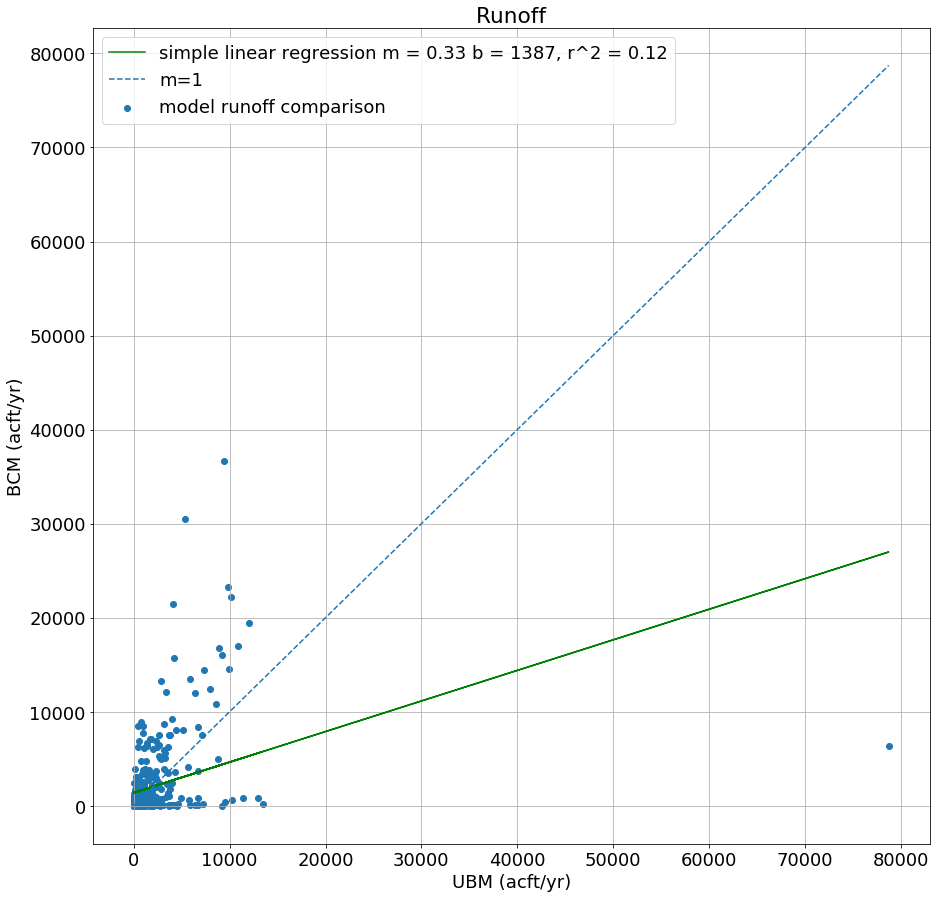

In [46]:
import statsmodels.api as sm

x = BM['UBM_run_acft'].values
Y = BM['BCM_run_acft'].values

X = sm.add_constant(x)
model = sm.OLS(Y,X)
est = model.fit()
const = est.params[0]
slope = est.params[1]

SIZE = 18
plt.rc('font', size=SIZE) 


plt.plot(x, est.predict(X), c='g', label='simple linear regression m = {:.2f} b = {:.0f}, r^2 = {:.2f}'.format(slope, const,est.rsquared))
plt.scatter(x,Y, label='model runoff comparison')
x2 = range(int(np.min(x)),int(np.max(x)))
plt.plot(x2,x2,'--', label='m=1')
plt.legend(loc='upper left')
plt.xlabel('UBM (acft/yr)')
plt.ylabel('BCM (acft/yr)')
plt.title('Runoff')
#plt.xlim(-100,10000)
#plt.ylim(-100,8000)
plt.grid()
plt.savefig('U:/GWP/Groundwater/Projects/BCM/Graphs/'+'runoff_bcm_vs_ubm.png')

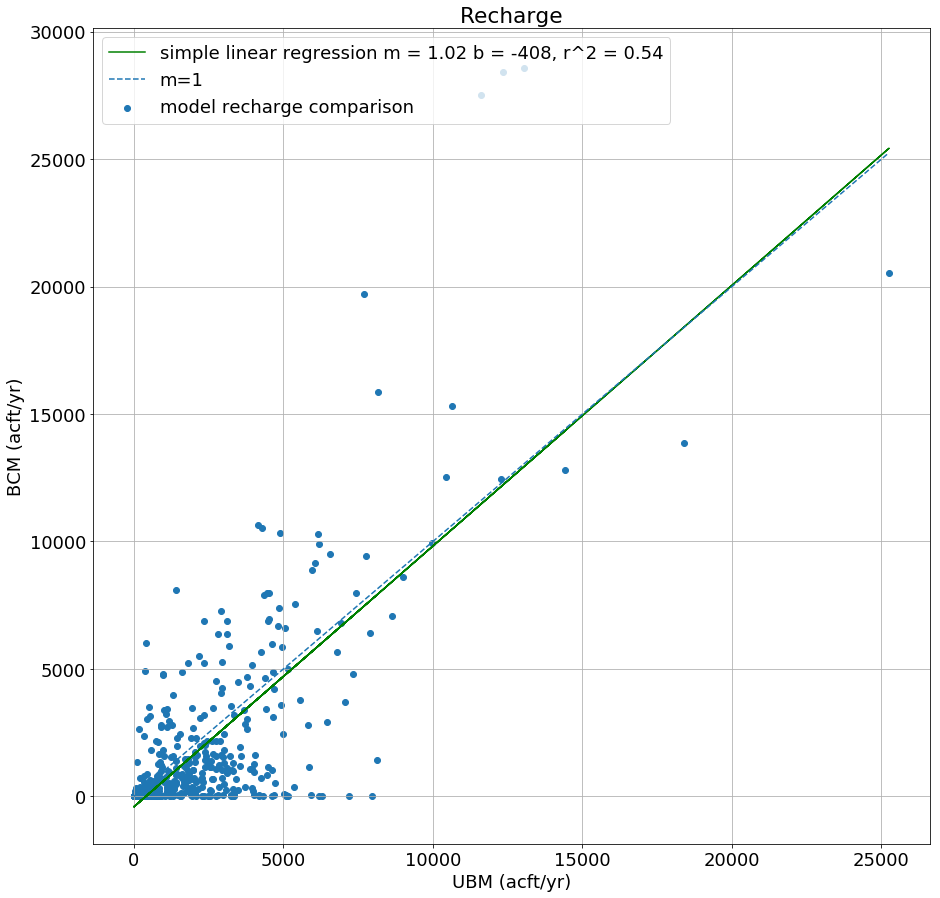

In [47]:
import statsmodels.api as sm

x = BM['UBM_rec_acft'].values
Y = BM['BCM_rec_acft'].values

X = sm.add_constant(x)
model = sm.OLS(Y,X)
est = model.fit()
const = est.params[0]
slope = est.params[1]

SIZE = 18
plt.rc('font', size=SIZE) 

plt.plot(x, est.predict(X), c='g', label='simple linear regression m = {:.2f} b = {:.0f}, r^2 = {:.2f}'.format(slope, const,est.rsquared))
plt.scatter(x,Y, label='model recharge comparison')
x2 = range(int(np.min(x)),int(np.max(x)))
plt.plot(x2,x2,'--', label='m=1')

plt.legend(loc='upper left')
plt.xlabel('UBM (acft/yr)')
plt.ylabel('BCM (acft/yr)')
plt.title('Recharge')
#plt.xlim(-100,10000)
#plt.ylim(-100,8000)
plt.grid()
plt.savefig('U:/GWP/Groundwater/Projects/BCM/Graphs/'+'recharge_bcm_vs_ubm.png')

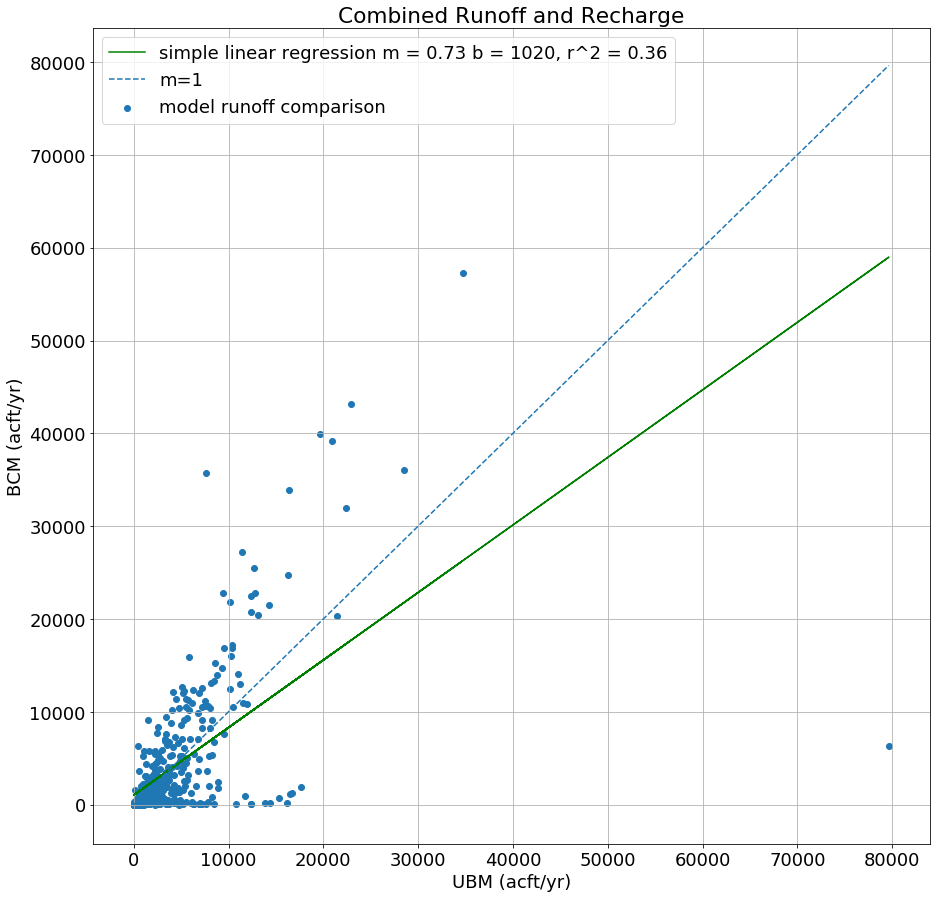

In [48]:
BM['UBM_comb_acft'] = BM['UBM_run_acft'] + BM['UBM_rec_acft']
BM['BCM_comb_acft'] = BM['BCM_run_acft'] + BM['BCM_rec_acft']

x = BM['UBM_comb_acft']
Y = BM['BCM_comb_acft']

X = sm.add_constant(x)
model = sm.OLS(Y,X)
est = model.fit()
const = est.params[0]
slope = est.params[1]

SIZE = 18
plt.rc('font', size=SIZE)   
#matplotlib.rc('pdf', fonttype=42)
plt.plot(x, est.predict(X), c='g', label='simple linear regression m = {:.2f} b = {:.0f}, r^2 = {:.2f}'.format(slope, const,est.rsquared))
plt.scatter(x,Y, label='model runoff comparison')
x2 = range(int(np.min(x)),int(np.max(x)))
plt.plot(x2,x2,'--', label='m=1')
plt.legend(loc='upper left')
plt.xlabel('UBM (acft/yr)')
plt.ylabel('BCM (acft/yr)')
#plt.xlim(-100,12000)
#plt.ylim(-100,14000)
plt.title('Combined Runoff and Recharge')
plt.grid()
plt.savefig('U:/GWP/Groundwater/Projects/BCM/Graphs/'+'combined_bcm_vs_ubm.png')

In [80]:
BM.to_clipboard()

In [ ]:
10133980

10217000

10172870

10242000

10234500

10113500

10011500

10155000

10172200

In [27]:
nw10128500 = wa.nwis("dv",'10128500','sites',startDT='2004-01-01',endDT='2015-01-01')

connection successful


In [50]:
nw = wa.nwis("dv",'10133980','sites',startDT='2004-01-01',endDT='2015-01-01')

connection successful


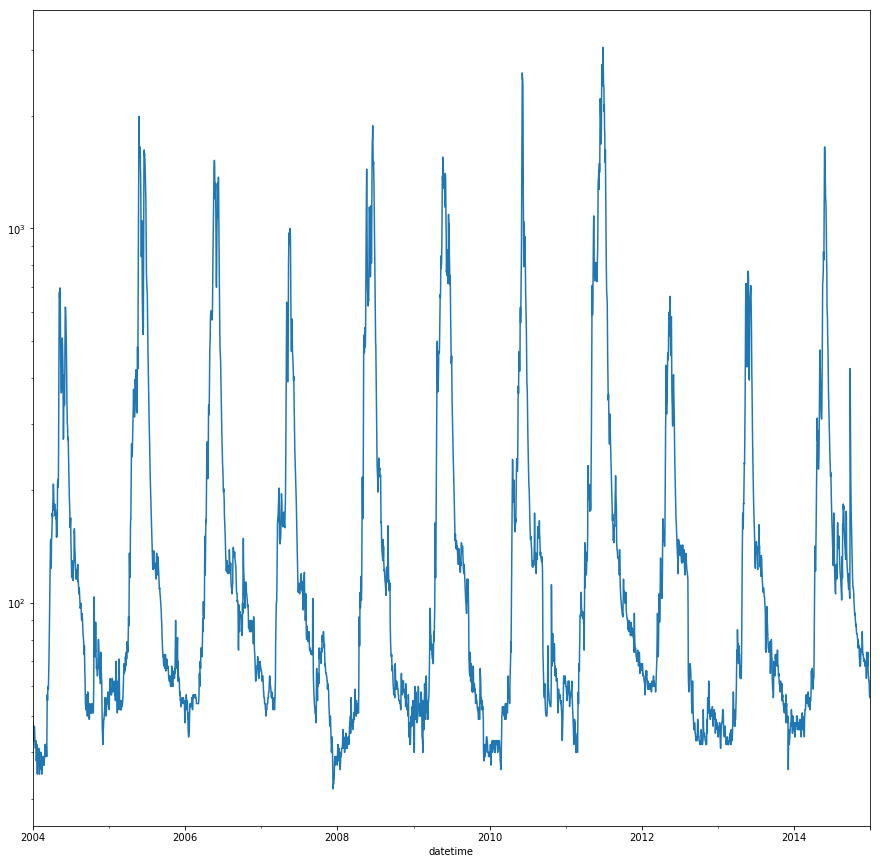

In [29]:
nw10128500.data.value.plot()
plt.yscale('log')

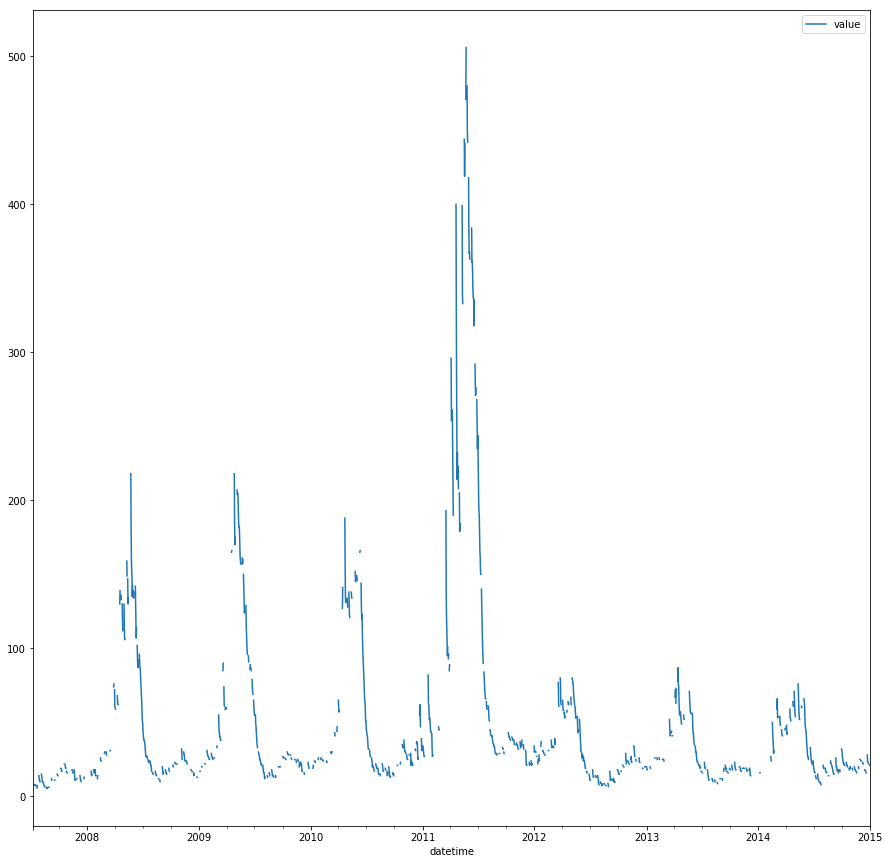

In [51]:
#nw.data.index = nw.data.index.to_datetime()

#nw.data.value.plot()

recess = nw.data[nw.data['value'].diff(2) < 0.0].copy()

recess = recess.resample('1D').mean()
recess.value.plot()
plt.legend()

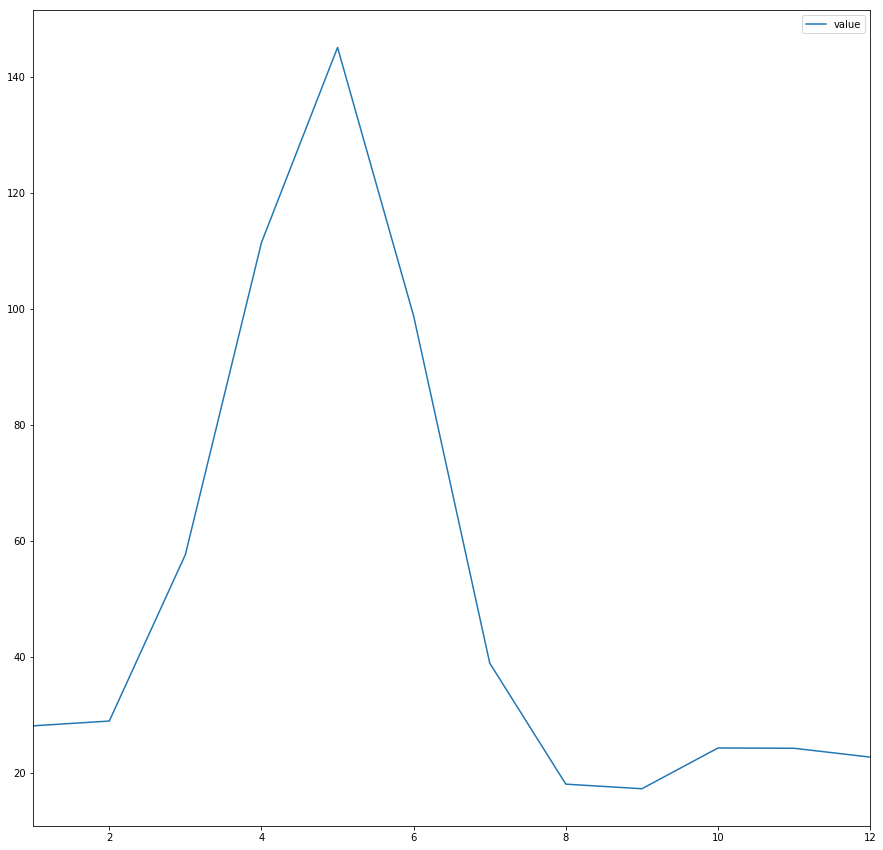

In [54]:
recess.groupby(recess.index.month).mean().plot()

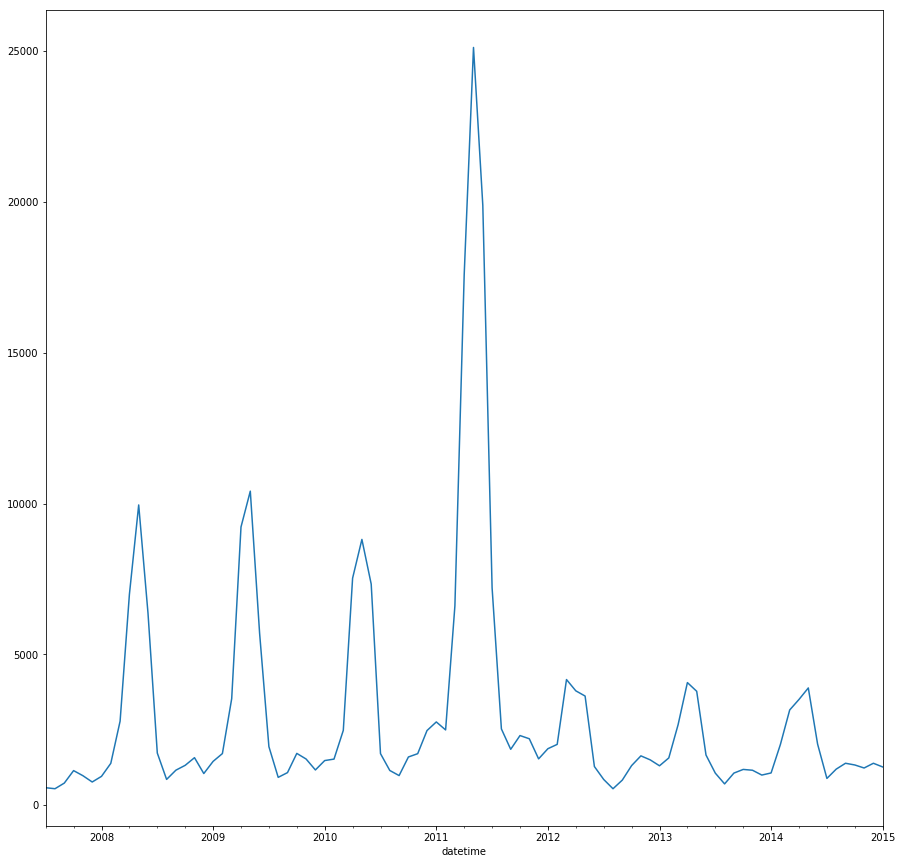

In [14]:
measflow = nw.data
measflow['afm'] = measflow.value *60.3307
monmeasflow = measflow['afm'].groupby(pd.TimeGrouper('M')).mean().plot()
#monmeasflow['afm']
#rungrp['volume_acft'].plot()
#recgrp['volume_acft'].plot()

In [ ]:
monmeasflow

## Snotel

In [16]:
# Set environment settings
arcpy.env.workspace = "H:/GIS/Results.gdb/"
arcpy.env.overwriteOutput = True
# Set local variables
memoryFeature = "H:/GIS/UT_BASE.gdb/Snotel"


inRasterList = []

monthRange = [1,12] 
yearRange = [2008,2015]

for y in range(yearRange[0],yearRange[1]+1): #set years converted here
    for m in range(monthRange[0],monthRange[1]+1): #set months converted here
        my = 'asw' + str(y) + str(m).zfill(2)

        arcpy.sa.ExtractValuesToPoints(memoryFeature, my, 'SnotelPoints',"INTERPOLATE", "VALUE_ONLY")
        memoryFeature = "in_memory/myMemoryFeature"
        arcpy.CopyFeatures_management('SnotelPoints', memoryFeature)
        arcpy.AlterField_management(memoryFeature,'RASTERVALU',my,my)
        inPointFeatures = 'SnotelPoints'
        print(my)

asw200801
asw200802
asw200803
asw200804
asw200805
asw200806
asw200807
asw200808
asw200809
asw200810
asw200811
asw200812
asw200901
asw200902
asw200903
asw200904
asw200905
asw200906
asw200907
asw200908
asw200909
asw200910
asw200911
asw200912
asw201001
asw201002
asw201003
asw201004
asw201005
asw201006
asw201007
asw201008
asw201009
asw201010
asw201011
asw201012
asw201101
asw201102
asw201103
asw201104
asw201105
asw201106
asw201107
asw201108
asw201109
asw201110
asw201111
asw201112
asw201201
asw201202
asw201203
asw201204
asw201205
asw201206
asw201207
asw201208
asw201209
asw201210
asw201211
asw201212
asw201301
asw201302
asw201303
asw201304
asw201305
asw201306
asw201307
asw201308
asw201309
asw201310
asw201311
asw201312
asw201401
asw201402
asw201403
asw201404
asw201405
asw201406
asw201407
asw201408
asw201409
asw201410
asw201411
asw201412


ExecuteError: Failed to execute. Parameters are not valid.
ERROR 000865: Input raster: asw201501 does not exist.
WARNING 000870: Output point features: Output H:/GIS/Results.gdb\SnotelPoints exists. It will be overwritten.
Failed to execute (ExtractValuesToPoints).


## SNODAS Processing

In [ ]:
quer = "SELECT HUC_12,YearMonth,SOURCE,variable,volume_acft FROM ubm.zbudget;"
budg = pd.read_sql_query(sql=quer,con=engine)
budg.ix[budg['SOURCE']=='MODIS','YearMonth'] = budg['YearMonth'].apply(lambda x: x[3:],1)
budg.ix[budg['SOURCE']=='SNODAS','YearMonth'] = budg['YearMonth'].apply(lambda x: x[-9:-3],1)
budg = budg[budg['YearMonth']>200000]
budg['dt'] = pd.to_datetime(budg.YearMonth,errors='coerce',format='%Y%m')
budg.drop(['SOURCE','YearMonth'],axis=1,inplace=True)
budg['HUC_08'] = budg['HUC_12'].apply(lambda x: str(x)[:-4], 1)
prov12 = budg[budg['HUC_12'].isin(['160202030403','160202030402','160202030404'])]
provo = prov12.groupby(['dt','variable']).sum()
provo.reset_index(inplace=True)
provpiv = provo.pivot(index='dt',columns='variable',values='volume_acft')
provpiv['precipitation'] = provpiv['precipitation']/100.0
provpiv = provpiv[provpiv['snow water equivalent']<100000]


In [ ]:
prov12 = budg[budg['HUC_12'].isin(['160202030403','160202030402','160202030404'])]
provo = prov12.groupby(['dt','variable']).sum()
provo.reset_index(inplace=True)
provpiv = provo.pivot(index='dt',columns='variable',values='volume_acft')
provpiv['precipitation'] = provpiv['precipitation']/100.0
provpiv = provpiv[provpiv['snow water equivalent']<100000]


In [ ]:
provpivmo = provpiv.groupby(provpiv.index.month).median()
provpivmo.to_csv()

In [ ]:
provpivmo.sum().to_clipboard(engineroute+"ZoneData.csv")

In [ ]:
provpiv

In [ ]:
provpivmo['total precip'].sum()

In [ ]:
provpiv['precipitation'] = provpiv['precipitation']/100.0
provpiv = provpiv[provpiv['snow water equivalent']<1e7]
provpiv.plot()

In [ ]:
pp

In [ ]:
pp = provpiv.dropna()
x = pp[u'precipitation'].values
y = pp[u'total precip'].values
w = pp.index.to_julian_date()
wa.graphs.scatterColor(x,y,x)

In [ ]:
provo.pivot(index='dt',columns='variable',values='volume_acft')